# Working on the DR problem

In [156]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
from sklearn import metrics
np.random.seed(123)

In [201]:
def generate_data(N=1000):
    #C = np.random.normal(size=N)
    
    p_logging = stats.norm(loc=0, scale=1)
    p_target = stats.norm(loc=1, scale=.5)
    A_logging = p_logging.rvs(size=N)
    A_target = p_target.rvs(size=N)
    Z = [0] * N + [1] * N
    X = np.concatenate([A_logging, A_target])
    clf = linear_model.LogisticRegression()
    clf = clf.fit(X.reshape(-1, 1), Z)
    proba = clf.predict_proba(A_logging.reshape(-1, 1))[:,1]
    pred_dr = proba / (1-proba)
    true_dr = p_target.pdf(A_logging)/p_logging.pdf(A_logging)
    kern = np.array([metrics.pairwise.rbf_kernel(np.array([[x]]), np.array([[y]]), gamma=1)[0] for x, y in zip(A_logging, A_target)]).reshape(-1)
    Y_logging = np.random.normal(loc=A_logging, scale=1, size=N)
    Y_target = np.random.normal(loc=A_target, scale=1, size=N)
    return pd.DataFrame({"true_dr":true_dr, "pred_dr": pred_dr, "p_logging": p_logging.pdf(A_logging), "kern": kern, "Y_logging": Y_logging, "Y_target": Y_target, "A_logging": A_logging, "A_target": A_target})

In [202]:
metrics.pairwise.rbf_kernel(np.array([1, 2, 3]).reshape(-1, 1), np.array([1, 2,  1]).reshape(-1, 1))

array([[1.        , 0.36787944, 1.        ],
       [0.36787944, 1.        , 0.36787944],
       [0.01831564, 0.36787944, 0.01831564]])

In [203]:
df = generate_data()

In [204]:
bootstraps = 100
N = 500
results = []
for i in range(bootstraps):
    df = generate_data(N)
    temp = dict()
    temp["Y_logging"] = np.mean(df["Y_logging"])
    temp["Y_target"] = np.mean(df["Y_target"])
    temp["true_dr_est"] = np.mean(df["Y_logging"] * df["true_dr"])
    temp["pred_dr_est"] = np.mean(df["Y_logging"] * df["pred_dr"])
    temp["self_norm_pred_dr_est"] = np.mean(df["Y_logging"] * df["pred_dr"]) / np.mean(df["pred_dr"])
    temp["kern_dr_est"] = np.mean(df["Y_logging"] * df["pred_dr"] * df["kern"]) #/ np.mean(df["pred_dr"] * df["kern"])
    temp["self_norm_kern_dr_est"] = np.mean(df["Y_logging"] * df["pred_dr"] * df["kern"]) / np.mean(df["pred_dr"] * df["kern"])
    temp["self_norm_kern_est"] = np.mean(df["Y_logging"] / df["p_logging"] * df["kern"]) / (np.mean(df["kern"]/df["p_logging"]))
    results.append(temp)

In [205]:
final_results = pd.DataFrame(results)

# Estimators

In this simple example we have actions and rewards and no context. The actions are all given by simple Gaussian distributions, and the rewards are given as $Y = A + \epsilon$. We want to compute the reward under the target using only the policies, plus the logging policy rewards

* Y_logging: just the mean of the logging policy rewards
* Y_target: mean of the target policy rewards (we wouldn't have this in practice)
* true_dr_est: computed as $\frac{1}{N} \sum_{i=1}^N Y_i w(A_i)$ where $w(A_i)$ is the true density ratio of the two actions (computed as the ratio of the normal density functions)
* pred_dr_est: computed as $\frac{1}{N} \sum_{i=1}^N Y_i \hat{w}(A_i)$ where $\hat{w}(A_i)$ is the predicted density ratio of the two actions (computed using a logistic regression classifier)
* self_norm_pred_dr_est: self normalized version of above
* kern_dr_est: the current PW method computed as $\frac{1}{Nh} \sum_{i=1}^N Y_i \hat{w}(A_i) K(A_i, A'_i)$ where a kernel (RBF) is used to smooth between $A'_i$ from target and $A_i$ from logging. Bandwidth arbitrarily chosen as $h=1$.
* self_norm_kern_dr_est: self normalized version of above
* self_norm_kern_est: the self-normalized estimator proposed by Kallus and Zhou


<AxesSubplot:ylabel='Frequency'>

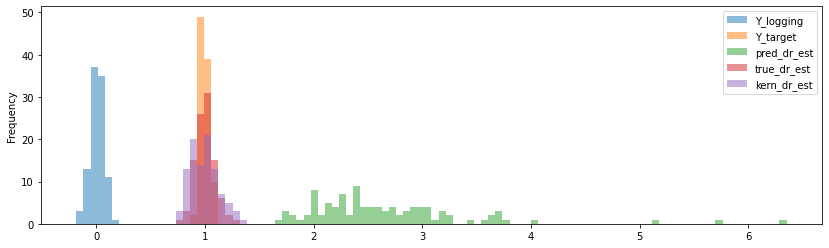

In [206]:
final_results[["Y_logging", "Y_target", "pred_dr_est", "true_dr_est", "kern_dr_est"]].plot(kind="hist", alpha = .5, bins=100, figsize=(14, 4))

In [182]:
final_results.describe()

,Y_logging,Y_target,true_dr_est,pred_dr_est,self_norm_pred_dr_est,kern_dr_est,self_norm_kern_dr_est,self_norm_kern_est
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002234,0.999054,0.959401,0.961564,0.965452,0.439126,0.973824,0.866403
std,0.071829,0.067589,0.163306,0.108347,0.094899,0.063598,0.103982,0.225393
min,-0.140056,0.836307,0.608534,0.734351,0.770035,0.334302,0.792115,0.503470
25%,-0.046783,0.949552,0.844344,0.890607,0.902016,0.395010,0.895576,0.714091
50%,0.002009,1.002073,0.948741,0.948967,0.959681,0.429960,0.967610,0.829726
75%,0.038823,1.047007,1.060618,1.031006,1.026800,0.474849,1.031418,0.952827
max,0.224887,1.138677,1.618736,1.249658,1.204075,0.638856,1.242510,1.911788


To summarize, the `pred_dr_est` estimator performs quite well, and is significantly less biased than `kern_dr_est`.  The self-normalized versions eliminate bias and both perform quite well, but leads one to wonder if the kernel is doing anything useful here. 